In [135]:
from pyspark.sql import SparkSession
import numpy as np
import math

In [168]:
spark = SparkSession.builder.appName('test').getOrCreate()

In [169]:
# df = spark.createDataFrame(data = [(['A', 1], [0.6, 0.0, 0.4]), 
#                                    (['B', 1], [0.5, 0.2, 0.3]), 
#                                    (['C', 1], [0.1, 0.1, 0.8])])
# df.show()
# df.printSchema()

In [170]:
df = spark.createDataFrame(data = [('A', ['A', 'B', 'C']), 
                                   ('B', ['B', 'C']), 
                                   ('C', ['C']),
                                   ('A', ['A', 'C']) ])

In [171]:
tmp = [x[0] for x in df.rdd.map(lambda x: (x[0], '')).reduceByKey(lambda x1, x2: x1).collect()]
bc_dict = spark.sparkContext.broadcast(dict(zip(tmp, range(len(tmp)))))
bc_length = spark.sparkContext.broadcast(len(tmp))
tmp

[u'A', u'C', u'B']

In [172]:
# def func(row):
#     result = []
#     for item in row._2:
#         if item == row._1: continue
#         result.append([ (row._1, item), 1.0 ])
#         result.append([ (row._1, ''), 1.0])
#     if len(result) == 0:
#         result.append([ (row._1, ''), 1.0])
#     return result

# def func2(row):
#     result = [float(0) for _ in range(bc_length.value)]
#     cnt = 0
#     for item in row[1]:
#         if not item[0][1]:
#             cnt = item[1]
#             continue
#         result[bc_dict.value[item[0][1]]] = float(round(item[1] / cnt, 6))
#     if np.sum(result) != 1.0:
#         result[bc_dict.value[row[0]]] = float(1.0 - np.sum(result))
#     return [([row[0], '1'], result)]
# result = df.rdd.flatMap(func).reduceByKey(lambda x1, x2: x1+x2).sortByKey().groupBy(lambda x: x[0][0]).flatMap(
#     func2).collect()
# result

In [176]:
def func(row):
    result = []
    for item in row._2:
        if item == row._1: continue
        result.append([ (row._1, item), 1 ])
    if len(result) == 0:
        result.append([ (row._1, row._1), 1])
    return result

def func2(row):
    result = [float(0) for _ in range(bc_length.value)]
    cnt = 0
    tmp = []
    for item in row[1]:
        cnt += item[1]
    for item in row[1]:
        result[bc_dict.value[item[0][1]]] = float(item[1]) / cnt
    return [([row[0], '1'], result)]
result = df.rdd.flatMap(func).reduceByKey(lambda x1, x2: x1+x2).groupBy(lambda x: x[0][0]).flatMap(
    func2)
result.collect()
# [((u'B', u'C'), 1), ((u'C', u'C'), 1), ((u'A', u'B'), 1), ((u'A', u'C'), 2)]

[([u'A', '1'], [0.0, 0.6666666666666666, 0.3333333333333333]),
 ([u'C', '1'], [0.0, 1.0, 0.0]),
 ([u'B', '1'], [0.0, 1.0, 0.0])]

In [177]:
newdf = spark.createDataFrame(result)

In [178]:
newdf.printSchema()

root
 |-- _1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- _2: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [179]:
newdf.show()
df = newdf

+------+--------------------+
|    _1|                  _2|
+------+--------------------+
|[A, 1]|[0.0, 0.666666666...|
|[C, 1]|     [0.0, 1.0, 0.0]|
|[B, 1]|     [0.0, 1.0, 0.0]|
+------+--------------------+



In [180]:
pos_list = spark.sparkContext.broadcast(dict([(v, k) for k, v in bc_dict.value.items()]))
bc_beta = spark.sparkContext.broadcast(0.85)
# print(pos_list.value)
def tran(row):
    print(row)
    return [ [ pos_list.value[i], 
               [ bc_beta.value * (float(row._1[1]) * row._2[i]), row._2 if pos_list.value[i] == row._1[0] else [] ] ] 
             for i in range(len(row._2)) ] + [ 
        [val, [(1-bc_beta.value) * float(row._1[1]) / len(pos_list.value) , []]] for val in pos_list.value.values() ]
error = 100
newdf = df
while(error > 1e-1):
    df = newdf
    new_result = df.rdd.flatMap(tran).reduceByKey(lambda x, y: [x[0] + y[0], x[1] + y[1]])
    old_result = df.rdd.map(lambda x: [x[0][0], [float(x[0][1]), x[1]] ])
    result = new_result.union(old_result)
    diff = result.map(lambda x: (x[0], x[1][0])).reduceByKey(lambda x1, x2: (x1 - x2) ** 2)
    error = math.sqrt( diff.map(lambda x: ('', x[1])).reduceByKey(lambda x1, x2: x1 + x2).collect()[0][1] )
    print(error)
    newdf = spark.createDataFrame(new_result.map(lambda x: [ [x[0], round(x[1][0], 6)], x[1][1] ]))

newdf.show()
df.show()

1.74658396751
0.340589294867
2.77555756156e-17
+-----------+--------------------+
|         _1|                  _2|
+-----------+--------------------+
|  [A, 0.15]|[0.0, 0.666666666...|
|[C, 2.6575]|     [0.0, 1.0, 0.0]|
|[B, 0.1925]|     [0.0, 1.0, 0.0]|
+-----------+--------------------+

+-----------+--------------------+
|         _1|                  _2|
+-----------+--------------------+
|  [A, 0.15]|[0.0, 0.666666666...|
|[C, 2.6575]|     [0.0, 1.0, 0.0]|
|[B, 0.1925]|     [0.0, 1.0, 0.0]|
+-----------+--------------------+



In [125]:
print(pos_list.value)

{0: u'A', 1: u'C', 2: u'B'}


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph() # 定义一个空图
node_list = ['sdaf', 'sahfi ajoij', 'an aoinion']
# edge_list = [('sdaf','sahfi ajoij', 0.1),('sahfi ajoij','an aoinion', 0.7)]
G.add_nodes_from(node_list)
# G.add_edges_from(edge_list)
pos = nx.spring_layout(G) 

G.add_edge('a','b',weight=0.6)
G.add_edge('a','c',weight=0.2)
G.add_edge('c','d',weight=0.1)
G.add_edge('c','e',weight=0.7)
G.add_edge('c','f',weight=0.9)
G.add_edge('a','d',weight=0.3)
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= 0.5]
print(elarge, esmall)
# nx.draw_networkx_nodes(G, pos, nodelist=['sdaf', 'sahfi ajoij'], node_size=1000, with_labels=True)
# nx.draw_networkx_nodes(G, pos, nodelist=['an aoinion'], node_size=100, with_labels=True)
# nx.draw_networkx_edges(G, pos, edgelist=[('sdaf','sahfi ajoij')], width=1)
# nx.draw_networkx_edges(G, pos, edgelist=[('sahfi ajoij','an aoinion')], 
#                        width=1, alpha=0.5, edge_color='b', style='dashed')
# nx.draw_networkx_labels(G, pos, dict( zip(node_list, node_list) ), font_size=8)
# plt.savefig('output.png')

SyntaxError: invalid syntax (<ipython-input-6-aa39e389ce5c>, line 10)

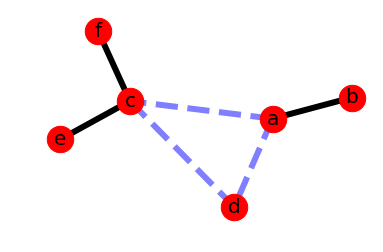

In [12]:
import networkx as nx

G=nx.Graph()

G.add_edge('a','b',weight=0.6)
G.add_edge('a','c',weight=0.2)
G.add_edge('c','d',weight=0.1)
G.add_edge('c','e',weight=0.7)
G.add_edge('c','f',weight=0.9)
G.add_edge('a','d',weight=0.3)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

In [360]:
a = dict([(1,1),(2,2),(3,3)])

In [364]:
[i for i in a.values()]

[1, 2, 3]

In [7]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 

G = nx.MultiDiGraph()

G.add_edge('a','a',weight=0.6)
G.add_edge('a','c',weight=0.2)
G.add_edge('a','e',weight=0.7)
G.add_edge('a','f',weight=0.9)
G.add_edge('a','d',weight=0.3)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos = nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=2,alpha=0.5,edge_color='b',style='dashed')
# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
plt.show()

ValueError: too many values to unpack

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([(0,1), (0,2), (1,1), (1,2)])
nx.write_dot(G,'graph.dot')

AttributeError: module 'networkx' has no attribute 'write_dot'

In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
G=nx.MultiDiGraph([('jumei', 'chongtian'), ('jumei','fenqile'), ('jumei','jumei')]
)
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
G.graph['graph'] = {'scale': '3'}
A = to_agraph(G)
A.layout('dot')                                                         
A.draw('multi.png')

In [183]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()
node_list = [0, 1, 2]
G.add_nodes_from(node_list)
pos = nx.spring_layout(G)
G.add_edge(0,1,weight=0.42082)
G.add_edge(0,2,weight=0.380616)
G.add_edge(1,2,weight=0.097705)
nx.draw(G,pos)

node_weights = [0.181207, 0.912326, 2.389324]
# nlarge=[node_list[i] for i in range(len(node_list)) if node_weights[i] >= 1]
# nsmall=[node_list[i] for i in range(len(node_list)) if node_weights[i] < 1]
for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos, nodelist=[node_list[i]], node_size=node_weights[i] * 1000, 
                           node_color='r' if node_list[i] > 0 else 'b')
eweight = 0.196798
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
name_list = ['jumei: %.6f' % eweight , 'chongtian: %.6f' % 0.901957, 'fenqile: %.6f' % 0.996100]
nx.draw_networkx_labels(G, pos, dict( zip(node_list, name_list) ), font_size=10)
import os
if os.path.exists('output.png'):
    os.remove('output.png')
plt.savefig('output.png')
plt.close()

In [184]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()
node_list = [0, 1, 2]
G.add_nodes_from(node_list)
pos = nx.spring_layout(G)
G.add_edge(0,2,weight=1.0)
G.add_edge(1,2,weight=1.0)
nx.draw(G,pos)

node_weights = [0.149999, 0.149999, 12.158094]
# nlarge=[node_list[i] for i in range(len(node_list)) if node_weights[i] >= 1]
# nsmall=[node_list[i] for i in range(len(node_list)) if node_weights[i] < 1]
for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos, nodelist=[node_list[i]], node_size=node_weights[i] * 1000, 
                           node_color='r' if node_list[i] > 0 else 'b')

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
name_list = ['jumei: %d' % 0 , 'chongtian: %d' % 0, 'fenqile: %.6f' % 0.963630]
nx.draw_networkx_labels(G, pos, dict( zip(node_list, name_list) ), font_size=10)
import os
if os.path.exists('output1.png'):
    os.remove('output1.png')
plt.savefig('output1.png')
plt.close()

In [188]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()
node_list = [0, 1, 2]
G.add_nodes_from(node_list)
pos = nx.spring_layout(G)
G.add_edge(0,1,weight=0.421565)
G.add_edge(0,2,weight=0.381289)
G.add_edge(1,2,weight=0.098043)
nx.draw(G,pos)

node_weights = [0.180196, 0.919625, 2.065577]
# nlarge=[node_list[i] for i in range(len(node_list)) if node_weights[i] >= 1]
# nsmall=[node_list[i] for i in range(len(node_list)) if node_weights[i] < 1]
for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos, nodelist=[node_list[i]], node_size=node_weights[i] * 1000, 
                           node_color='r' if node_list[i] > 0 else 'b')

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
name_list = ['jumei: %.6f' % 0.197146 , 'chongtian: %.6f' % 0.901957, 'fenqile: %.6f' % 0.996100]
nx.draw_networkx_labels(G, pos, dict( zip(node_list, name_list) ), font_size=10)
import os
if os.path.exists('output2.png'):
    os.remove('output2.png')
plt.savefig('output2.png')
plt.close()

In [78]:
import sys
a = sys.maxint
b = sys.maxint - 1
a - b > 0.1

True